# Bat Hunting Calls

In [1]:
import io
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter

Konstanten:

In [2]:
db_file_name = "batcallsv14.db"
table_name = "batcalls"

SQL-Datenbank einlesen:

In [3]:
data = pd.read_sql(table_name, f"sqlite:///{db_file_name}")
data.groupby('bat').agg('count')

,call,target,id,arr,db
bat,,,,,
Bartfledermaus,2393,2393,2393,2393,2393
Bechsteinfledermaus,329,329,329,329,329
Breitflügelfledermaus,2681,2681,2681,2681,2681
Fransenfledermaus,3040,3040,3040,3040,3040
GroßerAbendsegler,3005,3005,3005,3005,3005
GroßesMausohr,2366,2366,2366,2366,2366
KleinerAbendsegler,2884,2884,2884,2884,2884
Langohr,411,411,411,411,411
Mopsfledermaus,327,327,327,327,327


Serialisierte Numpy-Arrays einlesen:

In [4]:
data['arr'] = data['arr'].map(lambda bytes: np.load(io.BytesIO(bytes)))
data

,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"[157, 109, -92, -126, -10, 40, 11, -41, 45, 21...",skiba
1,46731,0,1,Bartfledermaus,"[-487, -92, 334, 561, 530, 229, -180, -511, -5...",skiba
2,49137,0,2,Bartfledermaus,"[-5, 120, 23, -22, 47, 15, -117, -154, -146, -...",skiba
3,49557,0,3,Bartfledermaus,"[-189, -179, -79, 34, 95, 37, -7, 35, 30, 26, ...",skiba
4,22197,0,4,Bartfledermaus,"[1, 0, -1, 0, 2, 5, 6, 7, 6, 5, 1, -4, -6, -9,...",skiba
...,...,...,...,...,...,...
51714,11775,18,7880,Zwergfledermaus,"[3, 91, 32, -82, -77, -37, -20, -2, 66, 30, -6...",skiba
51715,38802,18,7881,Zwergfledermaus,"[-14, 64, 27, -17, 22, 12, -8, 16, 13, 9, 10, ...",skiba
51716,25322,18,7882,Zwergfledermaus,"[-27, 92, 54, -27, 14, 10, -16, 13, 64, 33, -5...",skiba
51717,23866,18,7883,Zwergfledermaus,"[61, 80, 86, -33, -87, 29, 11, -26, 40, 70, 90...",skiba


Umwandlung int16 -> float32, Normalisierung auf [-1;1]

In [5]:
data['arr'] = data['arr'].map(lambda call: call.astype(np.float32) / 2.0**(16-1))
data

,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"[0.0047912598, 0.003326416, -0.0028076172, -0....",skiba
1,46731,0,1,Bartfledermaus,"[-0.014862061, -0.0028076172, 0.010192871, 0.0...",skiba
2,49137,0,2,Bartfledermaus,"[-0.00015258789, 0.0036621094, 0.0007019043, -...",skiba
3,49557,0,3,Bartfledermaus,"[-0.0057678223, -0.0054626465, -0.0024108887, ...",skiba
4,22197,0,4,Bartfledermaus,"[3.0517578e-05, 0.0, -3.0517578e-05, 0.0, 6.10...",skiba
...,...,...,...,...,...,...
51714,11775,18,7880,Zwergfledermaus,"[9.1552734e-05, 0.0027770996, 0.0009765625, -0...",skiba
51715,38802,18,7881,Zwergfledermaus,"[-0.0004272461, 0.001953125, 0.0008239746, -0....",skiba
51716,25322,18,7882,Zwergfledermaus,"[-0.0008239746, 0.0028076172, 0.0016479492, -0...",skiba
51717,23866,18,7883,Zwergfledermaus,"[0.0018615723, 0.0024414062, 0.0026245117, -0....",skiba


Bandpass-Filter, nur Frequenzen zwischen 1500Hz und 12,000Hz

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

data['arr'] = data['arr'].map(lambda call: butter_bandpass_filter(call, 1500, 12000, 44100, 5))
data

,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"[0.00020882230893271082, 0.0009980651541837105...",skiba
1,46731,0,1,Bartfledermaus,"[-0.0006477481812116571, -0.002768565801001311...",skiba
2,49137,0,2,Bartfledermaus,"[-6.6503920042264594e-06, 0.000132441044773677...",skiba
3,49557,0,3,Bartfledermaus,"[-0.00025138481775976014, -0.00126504816754052...",skiba
4,22197,0,4,Bartfledermaus,"[1.3300784008452918e-06, 5.433672665551425e-06...",skiba
...,...,...,...,...,...,...
51714,11775,18,7880,Zwergfledermaus,"[3.990235202535875e-06, 0.00013733815247357584...",skiba
51715,38802,18,7881,Zwergfledermaus,"[-1.8621097611834085e-05, 9.053600336378722e-0...",skiba
51716,25322,18,7882,Zwergfledermaus,"[-3.591211682282288e-05, -2.4341949092121615e-...",skiba
51717,23866,18,7883,Zwergfledermaus,"[8.11347824515628e-05, 0.00043786030466626025,...",skiba


Normalisierung:

In [7]:
data['arr'] = data['arr'].map(lambda call: (call - np.mean(call)) / np.std(call))
data

,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"[0.023500146989869186, 0.11215443193498724, 0....",skiba
1,46731,0,1,Bartfledermaus,"[-0.08146524693426499, -0.3480960720001129, -0...",skiba
2,49137,0,2,Bartfledermaus,"[-0.0017242419015283993, 0.03306417655714896, ...",skiba
3,49557,0,3,Bartfledermaus,"[-0.03105441485428307, -0.1564046011958408, -0...",skiba
4,22197,0,4,Bartfledermaus,"[-2.5258193459459957e-05, 9.13013452862939e-06...",skiba
...,...,...,...,...,...,...
51714,11775,18,7880,Zwergfledermaus,"[7.319888459029453e-05, 0.002010176507665997, ...",skiba
51715,38802,18,7881,Zwergfledermaus,"[-0.001567426754048205, 0.000620758417820513, ...",skiba
51716,25322,18,7882,Zwergfledermaus,"[-0.0006014420564289893, -0.000404535760215012...",skiba
51717,23866,18,7883,Zwergfledermaus,"[0.0008649904359816796, 0.004397458837696364, ...",skiba


In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut

import matplotlib.pyplot as plt

Formen eines großen Trainings-Arrays

In [8]:
X = np.concatenate(data['arr']).reshape(51719,-1)
print(X.shape)

y = np.array(data['target'])
print(y.shape)

(51719, 4410)
(51719,)


Erklärte Varianz bei verschiedener Anzahl an Hauptkomponenten

In [9]:
dims = range(1,6)

for dim in dims:
    pca = PCA(n_components=dim)
    pca_data = pca.fit_transform(X)
    print(f"{dim} Hauptkomponente(n): {sum(pca.explained_variance_ratio_)} variance explained")

1 Hauptkomponente(n): 0.011106186167259237 variance explained
2 Hauptkomponente(n): 0.020114905814884742 variance explained
3 Hauptkomponente(n): 0.028911342620918844 variance explained
4 Hauptkomponente(n): 0.03754151721839453 variance explained
5 Hauptkomponente(n): 0.04572366343086863 variance explained


Ergebnis ist ernüchternd. Bei Transformation in 2 (3) Dimensionen nur ca. 2 % (2,9 %) erklärte Varianz --> riesiger Informationsverlust
Test ob dennoch Erkenntnisse daraus gewonnen werden können

Zuerst 2 Dimensionen: Transformation und Visualisierung

In [10]:
pca_2d = PCA(2)
X_2d = pca_2d.fit_transform(X)

/tmp/ipykernel_2748/1799867658.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_2748/1799867658.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 19)


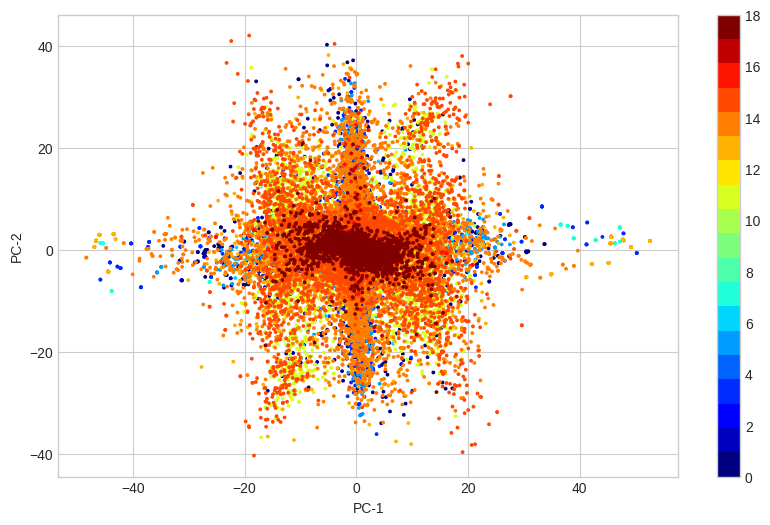

In [11]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 19)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s = 3,
            cmap = c_map , c = y)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

Einige Cluster erkennbar 
Jetzt KNN mit LOOCV (dauert aber lange)

In [103]:
k = range(1, 21)
scores_2d_knn = []

loo = LeaveOneOut()

for n_neighbors in k:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = []
    for i, (train_index, test_index) in enumerate(loo.split(X_2d)):
        knn.fit(X_2d[train_index,:], y[train_index])
        score.append(knn.score(X_2d[test_index,:], y[test_index]))
    scores_2d_knn.append(sum(score)/(i+1))

KeyboardInterrupt: 

In [109]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate

k = range(1, 101)
scores_2d_knn_cv = []

for n_neighbors in k:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn, X_2d, y)
    scores_2d_knn_cv.append(np.mean(scores["test_score"]))

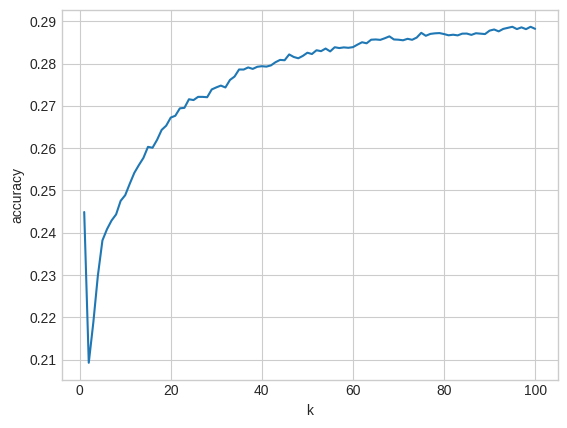

In [110]:
plt.plot(k, scores_2d_knn_cv)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

Nicht einmal 29 % bei KNN im Zweidimensionalen

Gradient Boosting mit Decision Trees und CV

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

boosting = GradientBoostingClassifier()

scores_boosting = cross_validate(boosting, X_2d[::10], y[::10])
print(scores_boosting["test_score"])

[0.1178744  0.11594203 0.12572534 0.11025145 0.10154739]


Vielleicht liefern die 3-dimensionalen Daten bessere Ergebnisse

In [12]:
pca_3d = PCA(3)
X_3d = pca_3d.fit_transform(X)

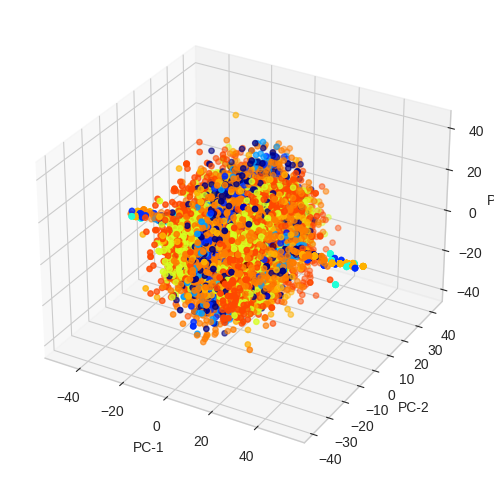

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], s = 15,
            cmap = c_map , c = y)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.show()

In [ ]:
scores_3d_knn = []

loo = LeaveOneOut()

for n_neighbors in k:
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = []
    for i, (train_index, test_index) in enumerate(loo.split(X_3d)):
        neigh.fit(X_3d[train_index,:], y[train_index])
        score.append(neigh.score(X_3d[test_index,:], y[test_index]))
    scores_3d_knn.append(sum(score)/(i+1))

In [18]:
k = range(1, 101)
scores_3d_knn_cv = []

for n_neighbors in k:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn, X_3d, y)
    scores_3d_knn_cv.append(np.mean(scores["test_score"]))

range(1, 101) {'fit_time': array([0.05110478, 0.04994583, 0.05112433, 0.05233502, 0.05208921]), 'score_time': array([0.57322621, 0.57601452, 0.55884409, 0.56522751, 0.56877685]), 'test_score': array([0.3066512 , 0.30036736, 0.29998067, 0.30104408, 0.29594895])}
range(1, 101) {'fit_time': array([0.05122924, 0.05417156, 0.05050159, 0.05251622, 0.05020189]), 'score_time': array([0.64575028, 0.62718463, 0.6242764 , 0.62678742, 0.6344192 ]), 'test_score': array([0.31322506, 0.30655452, 0.31177494, 0.31989559, 0.31344871])}
range(1, 101) {'fit_time': array([0.04989362, 0.05273938, 0.05306864, 0.05129123, 0.05089855]), 'score_time': array([0.66186452, 0.67204428, 0.67464542, 0.67238426, 0.67936587]), 'test_score': array([0.31950889, 0.31651199, 0.31815545, 0.32985305, 0.31973315])}
range(1, 101) {'fit_time': array([0.05182028, 0.05088353, 0.05149221, 0.0532248 , 0.05248141]), 'score_time': array([0.72562075, 0.71627092, 0.71642065, 0.71534681, 0.74385214]), 'test_score': array([0.32801624, 0.

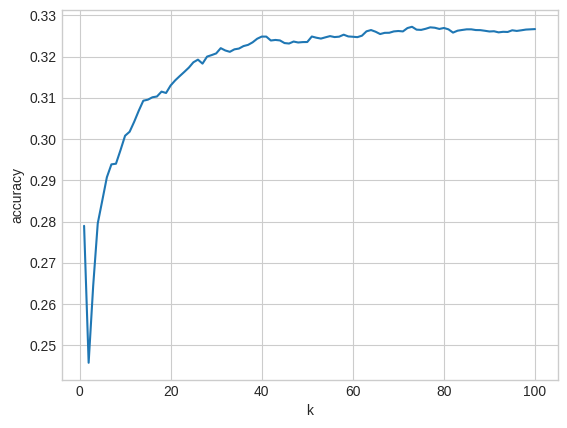

In [20]:
plt.plot(k, scores_3d_knn_cv)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()